In [ ]:
!mkdir data

## Download and preprocess data

In [ ]:
# Source: https://huggingface.co/blog/informer
from datasets import load_dataset

dataset = load_dataset("./monash_tsf.py", "traffic_hourly")

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 862
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 862
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 862
    })
})


In [ ]:
train_example = dataset["train"][0]
train_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [ ]:
for key in train_example.keys():
    print(key, train_example[key])

start 2015-01-01 00:00
target [0.004800000227987766, 0.007199999876320362, 0.004000000189989805, 0.0038999998942017555, 0.00419999985024333, 0.004000000189989805, 0.004399999976158142, 0.00419999985024333, 0.00860000029206276, 0.022299999371170998, 0.03269999846816063, 0.04089999943971634, 0.045099999755620956, 0.04619999974966049, 0.049800001084804535, 0.043699998408555984, 0.043699998408555984, 0.040699999779462814, 0.037700001150369644, 0.029500000178813934, 0.02590000070631504, 0.01360000018030405, 0.008200000040233135, 0.0038999998942017555, 0.0038999998942017555, 0.004000000189989805, 0.003800000064074993, 0.003700000001117587, 0.004100000020116568, 0.022600000724196434, 0.042899999767541885, 0.0421999990940094, 0.04529999941587448, 0.05490000173449516, 0.05770000070333481, 0.061400000005960464, 0.0658000037074089, 0.06300000101327896, 0.06520000100135803, 0.0649000033736229, 0.06400000303983688, 0.06080000102519989, 0.04729999974370003, 0.03480000048875809, 0.02759999968111515, 

In [ ]:
import pandas as pd

freq = "1h"

# Convert the train example to a dataframe
train_example_df = pd.DataFrame({
    'timestamp': pd.date_range(start=train_example['start'].to_timestamp(), periods=len(train_example['target']), freq=freq),
    'target': train_example['target'],
})

train_example_df.head()

,timestamp,target
0,2015-01-01 00:00:00,0.0048
1,2015-01-01 01:00:00,0.0072
2,2015-01-01 02:00:00,0.0040
3,2015-01-01 03:00:00,0.0039
4,2015-01-01 04:00:00,0.0042


In [ ]:
validation_example = dataset["validation"][0]
validation_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [ ]:
for key in validation_example.keys():
    print(key, train_example[key])

start 2015-01-01 00:00
target [0.004800000227987766, 0.007199999876320362, 0.004000000189989805, 0.0038999998942017555, 0.00419999985024333, 0.004000000189989805, 0.004399999976158142, 0.00419999985024333, 0.00860000029206276, 0.022299999371170998, 0.03269999846816063, 0.04089999943971634, 0.045099999755620956, 0.04619999974966049, 0.049800001084804535, 0.043699998408555984, 0.043699998408555984, 0.040699999779462814, 0.037700001150369644, 0.029500000178813934, 0.02590000070631504, 0.01360000018030405, 0.008200000040233135, 0.0038999998942017555, 0.0038999998942017555, 0.004000000189989805, 0.003800000064074993, 0.003700000001117587, 0.004100000020116568, 0.022600000724196434, 0.042899999767541885, 0.0421999990940094, 0.04529999941587448, 0.05490000173449516, 0.05770000070333481, 0.061400000005960464, 0.0658000037074089, 0.06300000101327896, 0.06520000100135803, 0.0649000033736229, 0.06400000303983688, 0.06080000102519989, 0.04729999974370003, 0.03480000048875809, 0.02759999968111515, 

In [ ]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [ ]:
from functools import lru_cache

import pandas as pd
import numpy as np

# lrucache is used to cache the results of the function so that if the function is called with the same arguments again, the result is returned from the cache instead of calling the function again
@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [ ]:
from functools import partial

freq = "1h"

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [ ]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper

num_of_variates = len(train_dataset)

# The MultivariateGrouper is used to group the time series data into multivariate time series data
train_grouper = MultivariateGrouper(max_target_dim=num_of_variates)
test_grouper = MultivariateGrouper(
    max_target_dim=num_of_variates,
    num_test_dates=len(test_dataset) // num_of_variates, # number of rolling test windows
)

multi_variate_train_dataset = train_grouper(train_dataset)
multi_variate_test_dataset = test_grouper(test_dataset)

In [ ]:
from gluonts.time_feature import get_lags_for_frequency

# Lags are the previous values of the time series data that are used to predict the future values (or we can say its the window size of the time series data)
lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 23, 24, 25, 47, 48, 49, 71, 72, 73, 95, 96, 97, 119, 120, 121, 143, 144, 145, 167, 168, 169, 335, 336, 337, 503, 504, 505, 671, 672, 673, 719, 720, 721]


Lags Sequence: [1, 2, 3, 4, 5, 6, 7, 23, 24, 25, 47, 48, 49, 71, 72, 73, 95, 96, 97, 119, 120, 121, 143, 144, 145, 167, 168, 169, 335, 336, 337, 503, 504, 505, 671, 672, 673, 719, 720, 721]


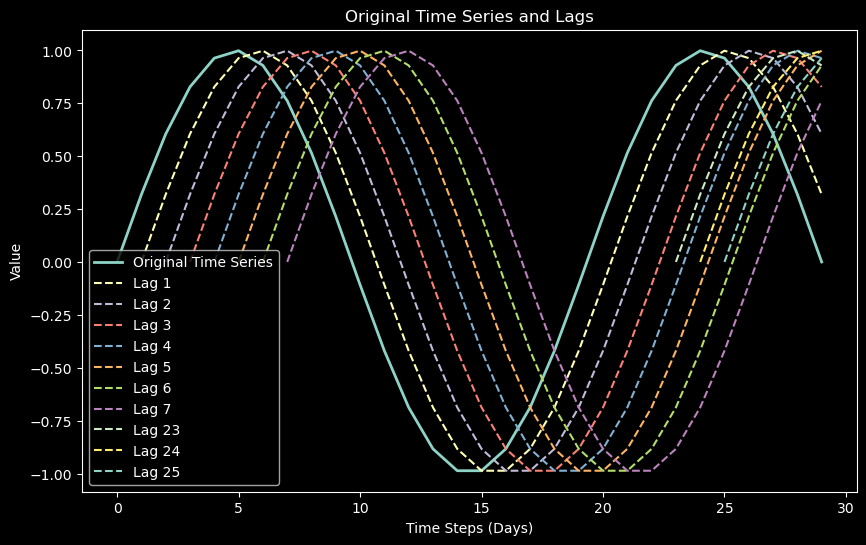

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from gluonts.time_feature import get_lags_for_frequency

# Set the time series frequency (daily)
freq = "h"

# Get the lag sequence for the given frequency
lags_sequence = get_lags_for_frequency(freq)
print("Lags Sequence:", lags_sequence)

# Example time series data (synthetic)
n_points = 30  # 30 days of data
time_series = np.sin(np.linspace(0, 3 * np.pi, n_points))  # Example sine wave as time series

# Plot the original time series and lagged values
plt.figure(figsize=(10, 6))
plt.plot(range(n_points), time_series, label="Original Time Series", linewidth=2)

# Plot lagged series
for lag in lags_sequence:
    if lag < n_points:
        lagged_series = np.concatenate([np.full(lag, np.nan), time_series[:-lag]])
        plt.plot(range(n_points), lagged_series, '--', label=f"Lag {lag}")

plt.title("Original Time Series and Lags")
plt.xlabel("Time Steps (Days)")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
from gluonts.time_feature import time_features_from_frequency_str

# Time features consists of: hour of the day, day of the week, day of the month, day of the year
time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function hour_of_day at 0x7ef04c5e5620>, <function day_of_week at 0x7ef04c5e5760>, <function day_of_month at 0x7ef04c5e58a0>, <function day_of_year at 0x7ef04c5e59e0>]


In [ ]:
from pandas.core.arrays.period import period_array

# All the time features will be normalized to the range [-1, 1]
timestamp = pd.Period("2015-01-01 01:00:01", freq=freq)
timestamp_as_index = pd.PeriodIndex(data=period_array([timestamp]))
additional_features = [
    (time_feature.__name__, time_feature(timestamp_as_index))
    for time_feature in time_features
]
print(dict(additional_features))

{'hour_of_day': array([-0.45652174]), 'day_of_week': array([0.]), 'day_of_month': array([-0.5]), 'day_of_year': array([-0.5])}


In [ ]:
from transformers import InformerConfig, InformerForPrediction

prediction_length = 48
#(batch size , time, V(embedding_Dim) * len(lags)+ number_of feature(hour of day , time of day))
(6,) +(5,)

config = InformerConfig(
    # in the multivariate setting, input_size is the number of variates in the time series per time step
    input_size=num_of_variates,
    # prediction length:
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags value copied from 1 week before:
    lags_sequence=[1, 24 * 7],
    # we'll add 5 time features ("hour_of_day", ..., and "age"):
    num_time_features=len(time_features) + 1,

    # informer params:
    dropout=0.1,
    encoder_layers=6,
    decoder_layers=4,
    # project input from num_of_variates*len(lags_sequence)+num_time_features to:
    d_model=64,
)

model = InformerForPrediction(config)

In [ ]:
from gluonts.time_feature import TimeFeature
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

In [ ]:
from transformers import PretrainedConfig


def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # create list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [ ]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional


def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

In [ ]:
from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from all the possible transformed time series, 1 in our case)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [ ]:
def create_backtest_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data)

    # we create a Validation Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "validation")

    # we apply the transformations in train mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=True)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # We create a test Instance splitter to sample the very last
    # context window from the dataset provided.
    instance_sampler = create_instance_splitter(config, "test")

    # We apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [ ]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
    num_workers=2,
)

test_dataloader = create_backtest_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_test_dataset,
    batch_size=32,
)


In [ ]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 264, 5]) torch.FloatTensor
past_values torch.Size([256, 264, 862]) torch.FloatTensor
past_observed_mask torch.Size([256, 264, 862]) torch.FloatTensor
future_time_features torch.Size([256, 48, 5]) torch.FloatTensor
future_values torch.Size([256, 48, 862]) torch.FloatTensor
future_observed_mask torch.Size([256, 48, 862]) torch.FloatTensor


In [ ]:
print(batch["past_time_features"][0])

tensor([[-0.1087,  0.5000, -0.1000,  0.3685,  4.2143],
        [-0.0652,  0.5000, -0.1000,  0.3685,  4.2143],
        [-0.0217,  0.5000, -0.1000,  0.3685,  4.2143],
        ...,
        [-0.2391,  0.0000,  0.2667,  0.3986,  4.2212],
        [-0.1957,  0.0000,  0.2667,  0.3986,  4.2212],
        [-0.1522,  0.0000,  0.2667,  0.3986,  4.2212]])


## Forward pass with multivariate output

In [ ]:
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)


In [ ]:
print("Loss:", outputs.loss.item())

Loss: -1072.9732666015625


In [ ]:
from accelerate import Accelerator
from torch.optim import AdamW

epochs = 25
loss_history = []

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(epochs):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        loss_history.append(loss.item())
        if idx % 100 == 0:
            print(loss.item())

-1077.0330810546875
-2197.125
-2449.11669921875
-2550.414794921875
-2620.671142578125
-2551.373779296875
-2581.16015625
-2696.6962890625
-2709.158203125
-2746.507080078125
-2786.083251953125
-2706.957763671875
-2769.494384765625
-2818.91796875
-2827.775390625
-2804.115966796875
-2838.010986328125
-2867.607421875
-2845.745361328125
-2850.280029296875
-2782.53125
-2774.965576171875
-2873.385986328125
-2868.3916015625
-2903.576171875


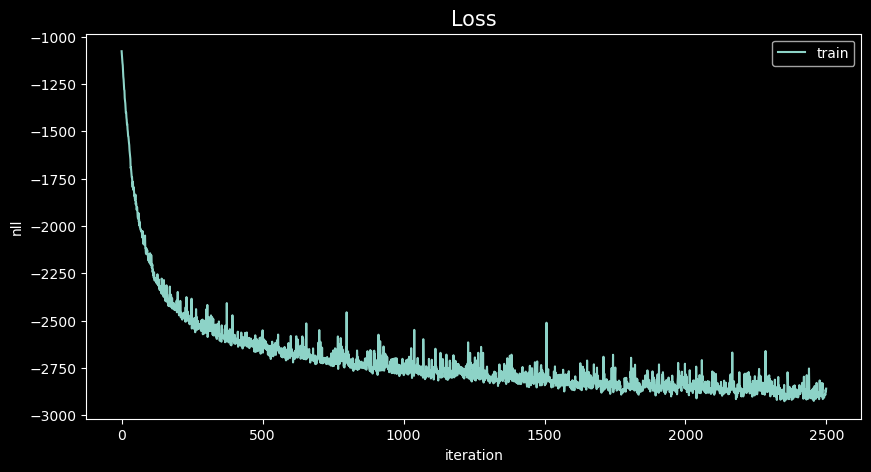

In [ ]:
# view training
loss_history = np.array(loss_history).reshape(-1)
x = range(loss_history.shape[0])
plt.figure(figsize=(10, 5))
plt.plot(x, loss_history, label="train")
plt.title("Loss", fontsize=15)
plt.legend(loc="upper right")
plt.xlabel("iteration")
plt.ylabel("nll")
plt.show()


# Inference

In [ ]:
model.eval()

forecasts_ = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts_.append(outputs.sequences.cpu().numpy())

forecasts = np.vstack(forecasts_)

In [ ]:
print(forecasts.shape)

(1, 100, 48, 862)


In [ ]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1).squeeze(0).T

mase_metrics = []
smape_metrics = []

for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
        training=np.array(training_data),
        periodicity=get_seasonality(freq),
    )
    mase_metrics.append(mase["mase"])

    smape = smape_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
    )
    smape_metrics.append(smape["smape"])

In [ ]:
print(f"MASE: {np.mean(mase_metrics)}")
print(f"sMAPE: {np.mean(smape_metrics)}")

MASE: 1.1860450755891316
sMAPE: 0.5201514020240587


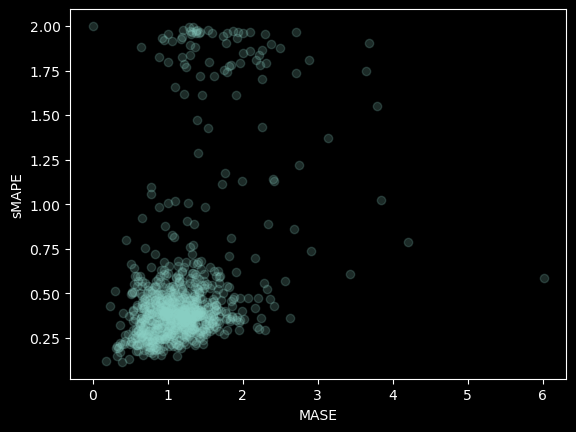

In [ ]:
plt.scatter(mase_metrics, smape_metrics, alpha=0.2)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()

In [ ]:
import matplotlib.dates as mdates


def plot(ts_index, mv_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=multi_variate_test_dataset[ts_index][FieldName.START],
        periods=len(multi_variate_test_dataset[ts_index][FieldName.TARGET]),
        freq=multi_variate_test_dataset[ts_index][FieldName.START].freq,
    ).to_timestamp()

    ax.xaxis.set_minor_locator(mdates.HourLocator())

    ax.plot(
        index[-2 * prediction_length :],
        multi_variate_test_dataset[ts_index]["target"][mv_index, -2 * prediction_length :],
        label="actual",
    )

    ax.plot(
        index[-prediction_length:],
        forecasts[ts_index, ..., mv_index].mean(axis=0),
        label="mean",
    )
    ax.fill_between(
        index[-prediction_length:],
        forecasts[ts_index, ..., mv_index].mean(0)
        - forecasts[ts_index, ..., mv_index].std(axis=0),
        forecasts[ts_index, ..., mv_index].mean(0)
        + forecasts[ts_index, ..., mv_index].std(axis=0),
        alpha=0.2,
        interpolate=True,
        label="+/- 1-std",
    )
    ax.legend()
    fig.autofmt_xdate()